Drill Hole Compound Likelihood Demo
===================================

In [33]:
%matplotlib inline

In [34]:
import matplotlib.pyplot as pl
import numpy as np
import logging

import revrand.optimize as opt
from revrand import glm
from revrand.basis_functions import BiasBasis, RandomRBF
from revrand.btypes import Parameter, Positive
from revrand.utils.datasets import gen_gausprocess_se
from revrand.mathfun.special import softplus

from uncoverml.likelihoods import Switching, UnifGauss

# Log output to the terminal attached to this notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

# Warning handling
#np.seterr(all='warn')
import warnings
warnings.filterwarnings('error')


Demo settings
-------------

In [35]:
# Dataset properties
N = 100
Ns = 250
offset = 20
lenscale_true = 1.2  # For the gpdraw dataset
noise_true = 0.1
hit_proportion = 0.5

fig_width = 15
fig_height = 10


Algorithm Settings
------------------

In [36]:
nbases = 20
lenscale = 1  # For all basis functions that take lengthscales
maxiter = 3000
batch_size = 10
use_sgd = True
regulariser = 1.
noise = 1.
#updater = opt.AdaDelta(rho=0.1, epsilon=1e-6)
updater = opt.Adam(alpha=0.01, epsilon=1e-5, beta1=0.1, beta2=0.3)


Make data
---------

In [37]:
#hit = np.random.binomial(n=1, p=hit_proportion, size=N).astype(bool)

N_nh = int(round(N * (1 - hit_proportion)))
N_h1 = int(round((N - N_nh) / 2))
N_h2 = N - (N_h1 + N_nh)
hit = np.concatenate((np.ones(N_h1), np.zeros(N_nh), np.ones(N_h2))).astype(bool)

#hit = np.zeros(N, dtype=bool)
not_hit = ~ hit

Xtrain, ftrain, Xtest, ftest = \
    gen_gausprocess_se(N, Ns, lenscale=lenscale_true, noise=0.0, scale=5)
    
# Sort X ascending so we get consistent slice of "not hit"
sind = np.argsort(Xtrain.flatten())
Xtrain = Xtrain[sind]
ftrain = ftrain[sind]

gtrain = ftrain + offset
gtest = ftest + offset

ytrain = np.empty(N)
ytrain[hit] = gtrain[hit] + np.random.randn(hit.sum()) * noise_true
ytrain[not_hit] = np.random.rand(not_hit.sum()) * gtrain[not_hit]


Set up likelihood and Basis
---------------------------

In [38]:
# Make parameter types
var = Parameter(noise**2, Positive())
regulariser = Parameter(regulariser, Positive())
lenscale_init = Parameter(lenscale, Positive(10))

# Likelihood
learn_args = (hit,)
pred_args = (np.ones(Ns, dtype=bool),)
like = Switching(var_init=var, lenscale=0.1)

#learn_args = ()
#pred_args = ()
#like = UnifGauss(lenscale=0.1)

# Regression Basis
basis = BiasBasis(offset=offset) \
    + RandomRBF(nbases, Xtrain.shape[1], lenscale_init)


Learning
--------

In [39]:
# Learning
params = glm.learn(Xtrain, ytrain, like, basis, regulariser=regulariser,
                   likelihood_args=learn_args, use_sgd=use_sgd,
                   batch_size=batch_size, maxiter=maxiter, updater=updater)


fmin: 10.109930423632358, fmax: 12.92378319394109, fshape: (10,)
fmin: 20.204408388227286, fmax: 22.908602062760643, fshape: (10,)
fmin: 20.566413274961647, fmax: 22.70995549360167, fshape: (10,)
fmin: 19.836086274859102, fmax: 21.76862749152001, fshape: (10,)
fmin: 19.85663434403026, fmax: 21.468165457683693, fshape: (10,)
fmin: 19.785128887621294, fmax: 21.310910756160702, fshape: (10,)
fmin: 19.819983101418856, fmax: 22.117713879060354, fshape: (10,)
fmin: 19.945507939371353, fmax: 21.643258560190215, fshape: (10,)
fmin: 20.383158382615285, fmax: 22.094450792692378, fshape: (10,)
fmin: 19.70605766145351, fmax: 21.2469395112865, fshape: (10,)
fmin: 19.362908943866096, fmax: 21.278359019100257, fshape: (10,)
fmin: 19.627621561995177, fmax: 22.129372916940117, fshape: (10,)
fmin: 19.294955480887076, fmax: 21.329415487028808, fshape: (10,)
fmin: 19.274832177234984, fmax: 22.107434996124173, fshape: (10,)
fmin: 19.151024072531957, fmax: 22.01616628303787, fshape: (10,)
fmin: 18.444544576

Prediction
----------

In [40]:

# Expected drill hole measurements (proxy for basement depth)
Ey, Vy, Eyn, Eyx = glm.predict_moments(Xtest, like, basis, *params,
                                       likelihood_args=pred_args)

m, C, bhypers = params[0], params[1], params[3]
fsamples = glm.sample_func(Xtest, basis, m, C, bhypers)
fmean = np.array(list(fsamples)).mean(axis=0)

# 95% confidence interval
y95n, y95x = glm.predict_interval(0.95, Xtest, like, basis, *params,
                                  multiproc=False,
                                  likelihood_args=pred_args)


Visualise
---------

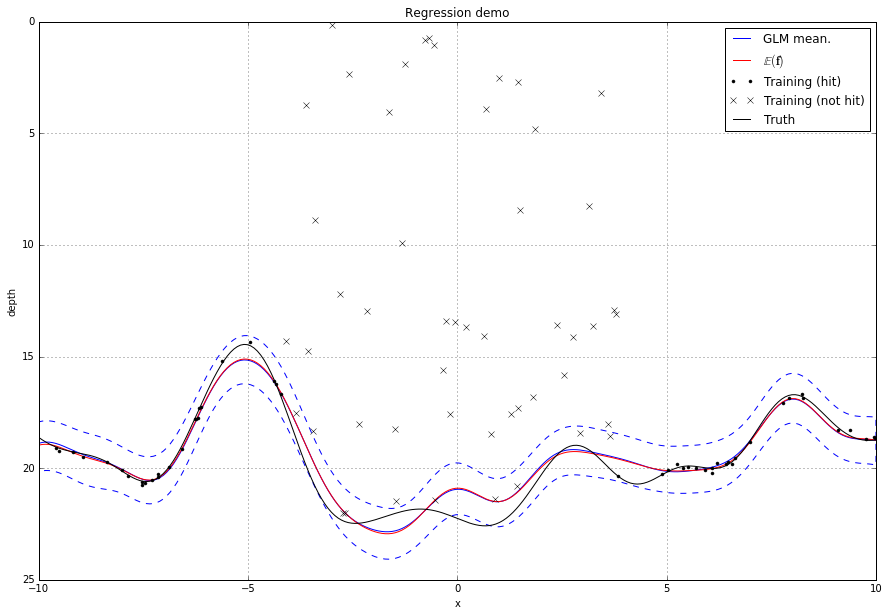

In [41]:
Xpl_t = Xtrain.flatten()
Xpl_s = Xtest.flatten()

# Regressor
pl.figure(figsize=(fig_width, fig_height))
pl.plot(Xpl_s, Ey, 'b-', label='GLM mean.')
pl.plot(Xpl_s, fmean, 'r-', label='$\mathbb{E}(\mathbf{f})$')
pl.fill_between(Xpl_s, y95n, y95x, facecolor='none', edgecolor='b', label=None,
                linestyle='--')

# Training/Truth
pl.plot(Xpl_t[hit], ytrain[hit], 'k.', label='Training (hit)')
pl.plot(Xpl_t[not_hit], ytrain[not_hit], 'kx', label='Training (not hit)')
pl.plot(Xpl_s, gtest, 'k-', label='Truth')

pl.gca().invert_yaxis()
pl.legend()
pl.grid(True)
pl.title('Regression demo')
pl.ylabel('depth')
pl.xlabel('x')

pl.show()
